
# EnergyFlowNetwork

In [1]:
# standard imports
import numpy as np
import os
import sys

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.utils import data_split, standardize, to_categorical

# other imports
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import EnergyFlow.ef_tools as ef_tools
import tools
################################### SETTINGS ###################################

# data controls
test_frac = 0.2

# efn parameters
"""
Required EFN Hyperparameters

input_dim : int
    The number of features for each particle.
Phi_sizes (formerly ppm_sizes) : {tuple, list} of int
    The sizes of the dense layers in the per-particle frontend module Φ.
    The last element will be the number of latent observables that the model defines.
F_sizes (formerly dense_sizes) : {tuple, list} of int
    The sizes of the dense layers in the backend module F.
"""

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (700, 500, 300, 100, 50), (700, 500, 300, 100, 50)
#Phi_sizes, F_sizes = (100, 50), (100, 50)

# network training parameters
num_epoch = 10
batch_size = 500
################################################################################

# load data
if os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file("/home/callum/Documents/bbb/user.jagrundy.20736236._000001.MiniNTuple.root")
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

X, tag = X[:,:,:3], X[:,:,3]

# convert labels to categorical
# our data was already categorical, ignore
Y = y
#print(Y[0])

print('Loaded jets')

# preprocess by centering jets and normalizing pts
# not actually sure why they do this
for x in X:
    mask = x[:,0] > 0
    etaphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= etaphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')
# do train/val/test split 
(pt_train, pt_val, pt_test, 
 eta_train, eta_val, eta_test,
 phi_train, phi_val, phi_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1], X[:,:,2], Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
efn = EFN(input_dim=3, output_dim=16, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
X_train = np.empty((len(pt_train), 18, 3))
X_train[:,:,0] = pt_train
X_train[:,:,1] = eta_train
X_train[:,:,2] = phi_train

X_val = np.empty((len(pt_val), 18, 3))
X_val[:,:,0] = pt_val
X_val[:,:,1] = eta_val
X_val[:,:,2] = phi_val

X_test = np.empty((len(pt_test), 18, 3))
X_test[:,:,0] = pt_test
X_test[:,:,1] = eta_test
X_test[:,:,2] = phi_test

efn.fit([pt_train, X_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([pt_val, X_val], Y_val),
        verbose=1)


Using TensorFlow backend.


Loaded jets
Finished preprocessing
Done train/val/test split
Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 700)    2800        phats_input[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 700)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 500)    350500      activation_1[0][0]               
________________

In [2]:
# get predictions on test data
preds = efn.predict([pt_test, X_test], batch_size=1000)

preds_max = np.argmax(preds, axis=1)
preds_arr = np.zeros((len(preds_max), 19))
for i, p in enumerate(preds_max):
    preds_arr[i][p+3] = 1

# chop off "no jet" jet
preds_arr = preds_arr[:,:-1]

100%|██████████| 15000/15000 [00:00<00:00, 151853.83it/s]

(15000, 18) (15000, 18) (15000, 18)



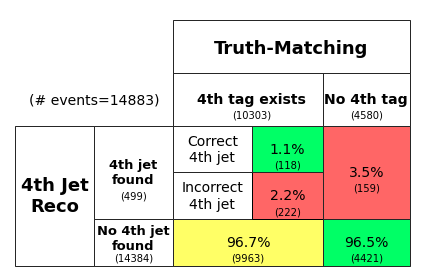

(1.1452974861690768,
 2.154712219741823,
 96.6999902940891,
 3.4716157205240177,
 96.52838427947597)

In [3]:
ones = np.ones((len(y), 3))

truths = np.concatenate((ones, y), axis=1)[:,:-1]


(truth_train, truth_val, truth_test, 
 tag_train, tag_val, tag_test) = data_split(truths, tag, val=val, test=test)

print(truth_test.shape, tag_test.shape, preds_arr.shape)
tools.evaluate_model(truth_test, tag_test, preds_arr)
